In [9]:
import os
import pandas as pd
import numpy as np
import PIL
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model,save_model
from keras.callbacks import ModelCheckpoint
from matplotlib.patches import Rectangle
import os
from scipy.misc import imsave

import keras
from keras.optimizers import Adam, SGD
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.applications import xception
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,concatenate, GlobalMaxPool2D, GlobalAvgPool2D
from keras.layers import Activation, Dropout, Flatten, Dense,Input, concatenate
from keras.layers import BatchNormalization
from keras.models import Model
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.advanced_activations import ELU
from math import sqrt
from keras.callbacks import History 
from tqdm import tqdm
from imblearn.over_sampling import ADASYN,SMOTE


In [15]:
trainFolder = '../input/plant-seedlings-classification/train'
# trainFolder = '../input/plant-seedlings-classification/test/*'
testFolder = "../input/plant-seedlings-classification/test/"
valFolder = '../input/seedlingsvalidation/validation/validation'

imgSize = (101,101,3)

In [18]:
datagen = ImageDataGenerator(validation_split=0.1,rescale=1/255.0,data_format='channels_last',rotation_range=360,
                             width_shift_range=0.3,
                             height_shift_range=0.3,
                             zoom_range=0.3,
                             horizontal_flip=True,vertical_flip=True)


trainGen = datagen.flow_from_directory(trainFolder, subset='training',batch_size=32, target_size=(101,101),class_mode='categorical')
valGen = datagen.flow_from_directory(trainFolder, subset='validation',batch_size=32, target_size=(101,101),class_mode='categorical')


classMap={'Loose Silky-bent':0,'Black-grass':1}
invClassMap={0:'Loose Silky-bent',1:'Black-grass'}

from keras.preprocessing import image


    

Found 4279 images belonging to 12 classes.
Found 471 images belonging to 12 classes.


In [19]:
def dense_set(inp_layer, n, activation, drop_rate=0.):
    dp = Dropout(drop_rate)(inp_layer)
    dns = Dense(n)(dp)
    bn = BatchNormalization(axis=-1)(dns)
    act = Activation(activation=activation)(bn)
    return act

def conv_layer(feature_batch, feature_map, kernel_size=(3, 3),strides=(1,1), zp_flag=False):
    if zp_flag:
        zp = ZeroPadding2D((1,1))(feature_batch)
    else:
        zp = feature_batch
    conv = Conv2D(filters=feature_map, kernel_size=kernel_size, strides=strides)(zp)
    bn = BatchNormalization(axis=3)(conv)
    act = LeakyReLU(1/10)(bn)
    return act

In [20]:
def get_model():
    inp_img = Input(shape=(101, 101, 3))

    # 51
    conv1 = conv_layer(inp_img, 64, kernel_size=(5,5), zp_flag=False)
    conv2 = conv_layer(conv1, 64, kernel_size=(5,5), zp_flag=False)
    mp1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv2)
    # 23
    conv3 = conv_layer(mp1, 128, zp_flag=False)
    conv4 = conv_layer(conv3, 128, zp_flag=False)
    mp2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv4)
    # 9
    conv7 = conv_layer(mp2, 256, zp_flag=False)
    conv8 = conv_layer(conv7, 256, zp_flag=False)
    conv9 = conv_layer(conv8, 256, zp_flag=False)
    mp3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv9)
    # 1
    # dense layers
    out1 = GlobalMaxPool2D()(mp3)
    out2 = GlobalAvgPool2D()(mp3)
    flt = Flatten()(mp3)
    out = concatenate([out1,out2,flt])
    ds1 = dense_set(out, 128, activation='relu')
    ds2 = dense_set(ds1, 64, activation='relu')
    out = Dense(12, activation='softmax')(ds2)

    model = Model(inputs=inp_img, outputs=out)
    
  
    return model

model = get_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 101, 101, 3)  0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 97, 97, 64)   4864        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 97, 97, 64)   256         conv2d_15[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_15 (LeakyReLU)      (None, 97, 97, 64)   0           batch_normalization_19[0][0]     
__________________________________________________________________________________________________
conv2d_16 

In [21]:
adam = Adam(lr=2 * 1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
sgd = SGD(lr=1 * 1e-1, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
                   optimizer=adam,
                  metrics=['accuracy'])

In [110]:
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=1e-5, patience=5, verbose=1)
checkPoint = ModelCheckpoint(filepath='./model_binary_build1_{epoch:02d}_{val_acc:.3f}.hdf5',monitor='val_acc',verbose=1,save_best_only=True,mode=min)

model.fit_generator(trainGen,validation_data=valGen,steps_per_epoch=2000,epochs=3,verbose=1,callbacks=[lr_reduce,checkPoint])



/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/callbacks.py:1062: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/callbacks.py:407: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/3
2000/2000 [==============================] - 1034s 517ms/step - loss: 0.2191 - acc: 0.9196 - val_loss: 0.7909 - val_acc: 0.7813

Epoch 00001: val_acc improved from -inf to 0.78132, saving model to ./model_binary_build1_01_0.781.hdf5
Epoch 2/3
2000/2000 [==============================] - 1036s 518ms/step - loss: 0.2000 - acc: 0.9256 - val_loss: 0.5306 - val_acc: 0.8514

Epoch 00002: val_acc improved from 0.78132 to 0.85138, saving model to ./model_binary_build1_02_0.851.hdf5
Epoch 3/3
2000/2000 [==============================] - 1032s 516ms/step - loss: 0.1789 - acc: 0.9348 - val_loss: 0.3439 - val_acc: 0.8917

Epoch 00003: val_acc improved from 0.85138 to 0.89172, saving model to ./model_binary_build1_03_0.892.hdf5


In [ ]:
# model.load_weights('../input/binarymodel-090/model_binary_build1_15_0.906.hdf5')

In [29]:
classMap = trainGen.class_indices
classMap.keys()

dict_keys(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet'])

In [32]:
invClassMap = dict([(classMap[k],k) for k in list(classMap.keys())])
invClassMap

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: 'Shepherds Purse',
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

## Testing

In [23]:
def read_img(filepath, size):
    img = image.load_img((filepath), target_size=size)
    img = image.img_to_array(img,data_format='channels_last')
    return img

In [35]:
validFolder = '../input/seedlingsvalidation/validation/validation'
os.listdir(validFolder)

['Maize',
 'Fat Hen',
 'Common Chickweed',
 'Cleavers',
 'Charlock',
 'Loose Silky-bent',
 'Small-flowered Cranesbill',
 'Black-grass',
 'Scentless Mayweed',
 'Sugar beet',
 'Common wheat',
 'Shepherds Purse']

In [106]:
def predFolder(folderPath,model,targetClass,targetIndex):
    
    imgList = os.listdir(folderPath)
    
    X=[]
    
    for i in range(len(imgList)):
        img = read_img(os.path.join(folderPath,imgList[i]),(101,101))
        X.append(img)
        
    
    X = np.array(X)
    X = X/255.0
    
    pred = model.predict(X)
    pred = np.argmax(pred,axis=1)
    correctPreds = sum(pred==targetIndex)
    accuracy = correctPreds/float(len(imgList))
    return([accuracy,correctPreds,len(imgList)])
    

In [87]:
def TTAPred(img,model):
    
    aug_imgs=[]
    
    aug_imgs.append(img)
    aug_imgs.append(img)
    aug_imgs.append(iaa.Fliplr(1.0).augment_image(img))
    aug_imgs.append(iaa.Flipud(1.0).augment_image(img))
    aug_imgs.append(iaa.Crop((5,16)).augment_image(img))
    aug_imgs.append(iaa.GaussianBlur(sigma=(0, 3.0)).augment_image(img))
    aug_imgs.append(iaa.ContrastNormalization((0.75, 1.5)).augment_image(img))
    aug_imgs.append(iaa.Affine(scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},rotate=(-25, 25),shear=(-8, 8)).augment_image(img))
    aug_imgs.append(iaa.Multiply((0.8, 1.2), per_channel=0.2).augment_image(img))
    
    X = np.array(aug_imgs)
    X = X/255.0
    
    
    pred = model.predict(X)
    pred = np.argmax(pred,axis=1)
    predCount = (np.array(np.unique(pred,return_counts=True)).T)
    
    finalPred = sorted(predCount,key=lambda x : -x[1])[0][0]
    
    return (finalPred )
    
def TTAPredFolder(folderPath,model,targetClass,targetIndex):
    
    imgList = os.listdir(folderPath)
    
    X=[]
    correctPreds = 0.0
    
    for i in range(len(imgList)):
        img = read_img(os.path.join(folderPath,imgList[i]),(101,101))
        pred = TTAPred(img,model)
        if pred == targetIndex:
            correctPreds += 1
        
    accuracy = correctPreds/float(len(imgList))
    return([accuracy,correctPreds,len(imgList)])
    

**Testing without Augmentation**

In [111]:
folderList = os.listdir(validFolder)

totalCorrect = 0.0
totalImages = 0.0

for i in range(len(folderList)):
    folderPath = os.path.join(validFolder, folderList[i])
    acc,correct,totalImgs = predFolder(folderPath,model, folderList[i], classMap[folderList[i]])
    print("Class : {} Accuracy : {}  {}".format(folderList[i], acc, correct/float(totalImgs)))
    
    totalCorrect += correct
    totalImages += totalImgs

finalAcc = totalCorrect/float(totalImages)
print("Final accuract : {}".format(finalAcc))
    
    
    
    

Class : Maize Accuracy : 0.967741935483871  0.967741935483871
Class : Fat Hen Accuracy : 0.9791666666666666  0.9791666666666666
Class : Common Chickweed Accuracy : 0.9682539682539683  0.9682539682539683
Class : Cleavers Accuracy : 0.96875  0.96875
Class : Charlock Accuracy : 0.8571428571428571  0.8571428571428571
Class : Loose Silky-bent Accuracy : 0.9733333333333334  0.9733333333333334
Class : Small-flowered Cranesbill Accuracy : 1.0  1.0
Class : Black-grass Accuracy : 0.5806451612903226  0.5806451612903226
Class : Scentless Mayweed Accuracy : 0.9375  0.9375
Class : Sugar beet Accuracy : 1.0  1.0
Class : Common wheat Accuracy : 1.0  1.0
Class : Shepherds Purse Accuracy : 0.9523809523809523  0.9523809523809523
Final accuract : 0.9408033826638478


**Testing with Augmentation**

In [ ]:
folderList = os.listdir(validFolder)

totalCorrect = 0.0
totalImages = 0.0

for i in range(len(folderList)):
    folderPath = os.path.join(validFolder, folderList[i])
    acc,correct,totalImgs = TTAPredFolder(folderPath,model, folderList[i], classMap[folderList[i]])
    totalCorrect += correct
    totalImages += totalImgs
    print("Class : {} Accuracy : {}".format(folderList[i], acc))
    
    
finalAcc = totalCorrect/float(totalImages)
print("Final accuracy : {}".format(finalAcc))

In [103]:
TTAPred(img,model)

7

In [82]:
sorted(np.unique(b,return_counts=True),key=lambda x : -x[1])[0][0]

7

In [45]:
img = read_img(os.path.join(trainFolder,'Maize','a5c2eec2d.png'),(101,101))

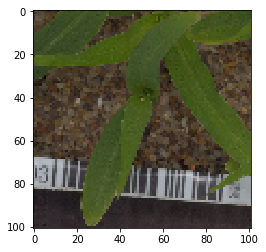

In [47]:
plt.imshow(img/255.0)

In [48]:
from imgaug import augmenters as iaa

In [67]:
s = iaa.Crop((5,16)).augment_image(img)
# help(iaa.Crop((0,16))

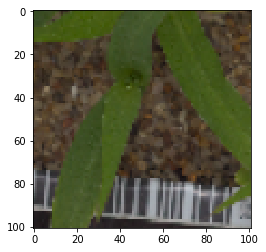

In [68]:
plt.imshow(s.augment_image(img)/255.0)

In [ ]:
def predFolder(folderPath,targetClass,targetIndex,model):
    
    imgList = os.listdir(folderPath)
    
    X=[]
    
    for i in range(len(imgList)):
        img = read_img(os.path.join(folderPath,imgList[i]),(51,51))
        X.append(img)
        
    
    X = np.array(X)
    X = X/255.0
    
    pred = model.predict(X)
    pred = np.argmax(pred,axis=1)
    correctPreds = sum(pred==targetIndex)
    accuracy = correctPreds/float(len(imgList))
    return([accuracy,correctPreds,len(imgList)])
    

In [ ]:
def predTestFolder(folderPath,model):
    
    imgList = os.listdir(folderPath)
    
    X=[]
    
    for i in range(len(imgList)):
        img = read_img(os.path.join(folderPath,imgList[i]),(101,101))
        X.append(img)
    
    X = np.array(X)
    X = X/255.0
    
    pred = model.predict(X)
    pred = np.argmax(pred,axis=1)
    predFinal = [invClassMap[x] for x in pred]
    
    df = pd.DataFrame({'file':imgList,'species':predFinal})
    
    return(df)
    
    

In [ ]:
pred = predTestFolder(testFolder,model)
pred.columns = ['file','binarySpecies']

In [ ]:
mainPred = pd.read_csv('../input/mainpred-095/Submission_test_0.953.csv')

In [ ]:
mainPred.head()

In [ ]:
pred = pd.merge(pred,mainPred,on='file',how='inner')
pred.head()

In [ ]:
e = pred.values

In [ ]:
e

In [ ]:
for i in range(len(e)):
    
    if e[i][2] in ['Black-grass','Loose Silky-bent']:
        if e[i][1]!=e[i][2]:
            print("Yes {}".format(e[i][2]))
        e[i][2] = e[i][1]

In [ ]:
finalPred = pd.DataFrame(e,columns=['file','binaryPred','species'])


In [ ]:
finalPred = finalPred.drop(['binaryPred'],axis=1)

In [ ]:
finalPred.to_csv('./Submission_2model_90.1.csv',header=True,index=False,index_label=False)